In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from transformers import TimesformerModel, TimesformerConfig
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
from itertools import product
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


2025-05-25 23:52:20.750134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748217140.942883      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748217140.997678      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = ["A", "B1", "B2", "B4", "B5", "B6", "G"]
train = '/kaggle/input/diploma-dataset/train'
val = '/kaggle/input/diploma-dataset/validation'
test = '/kaggle/input/diploma-dataset/test'

NUM_CLASSES = 7
EPOCHS = 5
IMAGE_SIZE = 224


In [3]:
print(device)

cuda


In [4]:
def preprocess_frame(frame):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(frame)

def extract_frames(video_path, frame_rate=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_rate == 0:
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames

In [5]:
def extract_label(file):
    parts = file[:-4].split("label_")
    if len(parts) < 2:
        return 0

    labels = parts[1].split('-')
    for i, cls in enumerate(classes):
        if cls in labels:
            return i
    return 0

def create_dataset_from_folder(folder_path):
    video_files = []
    labels = []

    for file in os.listdir(folder_path):
        if file.endswith((".mp4", ".avi", ".mkv")):  # adjust extensions if needed
            full_path = os.path.join(folder_path, file)
            label = extract_label(file)
            video_files.append(full_path)
            labels.append(label)
    return video_files, labels


In [6]:
class VideoDataset(Dataset):
    def __init__(self, video_files, labels, frame_rate=5, max_frames=30):
        self.video_files = video_files
        self.labels = labels
        self.frame_rate = frame_rate
        self.max_frames = max_frames

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        label = self.labels[idx]
    
        frames = extract_frames(video_path, self.frame_rate)  # frames - список усіх кадрів
    
        if len(frames) > self.max_frames:
            indices = np.linspace(0, len(frames) - 1, self.max_frames).astype(int)
            frames = [frames[i] for i in indices]
        elif len(frames) < self.max_frames:
            pad_count = self.max_frames - len(frames)
            pad = [torch.zeros_like(preprocess_frame(frames[0]))] * pad_count
            frames.extend(pad)
    
        processed_frames = [preprocess_frame(f) for f in frames]
    
        video_tensor = torch.stack(processed_frames)  # (T, C, H, W)
        return video_tensor, label

In [7]:
from transformers import TimesformerConfig, TimesformerModel

class VideoClassifier(nn.Module):
    def __init__(self, num_classes, num_frames=30):
        super(VideoClassifier, self).__init__()
        
        config = TimesformerConfig.from_pretrained(
            'facebook/timesformer-base-finetuned-k400',
            num_frames=num_frames
        )
        
        self.timesformer = TimesformerModel.from_pretrained(
            'facebook/timesformer-base-finetuned-k400',
            config=config,
            ignore_mismatched_sizes=True
        )
        
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, x):
        # x: (B, T, C, H, W)
        outputs = self.timesformer(pixel_values=x).last_hidden_state
        pooled = outputs.mean(dim=1)
        return self.classifier(pooled)


In [8]:
x_train, y_train = create_dataset_from_folder(train)
x_val, y_val = create_dataset_from_folder(val)
x_test, y_test = create_dataset_from_folder(test)

In [9]:
train_dataset = VideoDataset(x_train, y_train)
val_dataset = VideoDataset(x_val, y_val)

In [10]:
import gc
gc.collect()  # виклик збирача сміття
torch.cuda.empty_cache()

In [11]:
param_grid = {
    'learning_rate': [0.0001],
    'weight_decay': [0.1],
    'batch_size': [2],
}

best_val_acc = 0
best_params = None


In [12]:
test_dataset = VideoDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
for lr, wd, bs in product(param_grid['learning_rate'], param_grid['weight_decay'], param_grid['batch_size']):
    print(f"\nTraining with lr={lr}, weight_decay={wd}, batch_size={bs}")

    # Prepare dataloaders with batch_size=bs
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

    # Initialize model and move to device
    model = VideoClassifier(num_classes=NUM_CLASSES).to(device)

    # Define optimizer with current lr and weight_decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True):
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Train loss: {total_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        correct, total = 0, 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(device), labels.to(device)
                outputs = model(videos)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # Classification report
        target_names = classes
        print("Classification report:")
        print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

        cm = confusion_matrix(all_labels, all_preds)
        
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    # Save best params
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_params = {'learning_rate': lr, 'weight_decay': wd, 'batch_size': bs}
        torch.save(model.state_dict(), "best_model.pth")

print(f"\nBest params: {best_params}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

In [16]:
test_dataset = VideoDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
model.eval()
correct, total = 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Validation Accuracy: {test_accuracy:.2f}%")

target_names = classes
print("Validation report:")
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

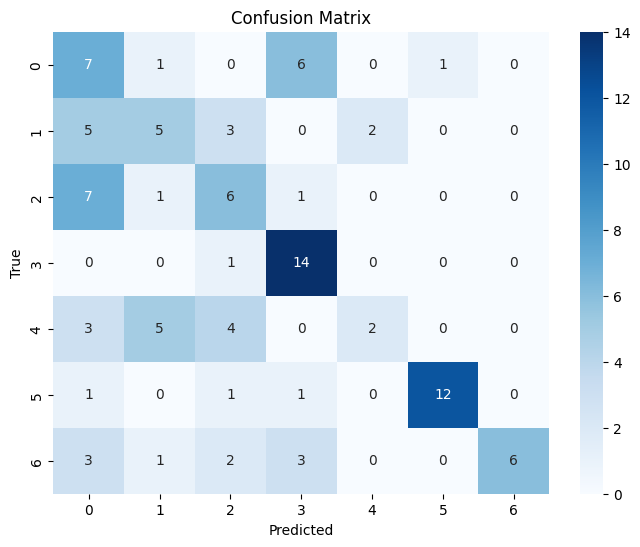

In [18]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()